In [1]:
import fabio
from ipywidgets import interact
import PyMca5 as mca
from scipy.signal import fftconvolve
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'png'

Define directories for .edf and .spec files:

In [2]:
edfdir = '/data/id01/inhouse/leake/hc2615/id01/detector/align2/'
specdir = '/data/id01/inhouse/leake/hc2615/id01/spec/'
specfile = 'align2.spec'

Define a function to load .edf images and store them in a 3D array where the third dimension follows the images acquired within a scan (in this case it corresponds to *time*):

In [10]:
def load_edf(scan_numbers, specdir, edfdir, specfile):
    """
    Accepts a list of scans. Have a look in the spec file with PyMca to see what
    scans  you are interested into.
    """
    
    all_scans = dict()
    stack_total = dict()
    
    for scan_no in scan_numbers:
        # Load specfile
        sf = mca.specfilewrapper.Specfile(specdir+specfile)
        # Specify scan number and load it
        scan = sf[scan_no-1]
        # Store number of imgs referred to in specfile
        edf_num = scan.alllabels().index('mpx4inr')
        img_num = scan.data()[edf_num].shape[0]
        # Find the filename of the first edf file in the scan
        fname0 = scan.header('ULIMA')[0].split('/')[-1]
        # Load the first .edf file
        edf0 = fabio.open(edfdir + fname0)
        # Load the rest of the edf files, place them in an array
        scan_all = [edf0]
        for n in range(img_num-1):
            scan_all.append(scan_all[n].next())
        scan_all = np.array(scan_all)
        # Stack data so that each scan is a (512,512,img_num) 3D array
        for image in range(scan_all.shape[0]):
            scan_all[image] = scan_all[image].data
        scan_all = tuple(scan_all)
        stack = np.dstack(scan_all)+1
        stack_total[scan_no] = stack
        
    return stack_total

Load the first image of a scan to estimate an ROI over which perform the ACF:

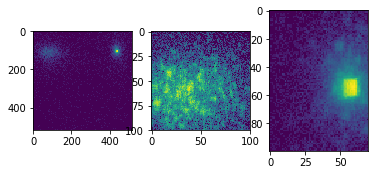

In [11]:
scan18 = load_edf([18],specdir,edfdir,specfile)[18]

# Select an ROI and visualise it
i1, i2 = 50, 150
j1, j2 = 50, 150
# Do the same for the Bragg
h1, h2 = 50, 150
k1, k2 = 380, 450

roi1_18 = scan18[i1:i2,j1:j2,0]
roi2_18 = scan18[h1:h2,k1:k2,0]

pl.subplot(1,3,1)
pl.imshow(np.log(scan18[:,:,0]))
pl.subplot(1,3,2)
pl.imshow(np.log(roi1_18));
pl.subplot(1,3,3)
pl.imshow(np.log(roi2_18));

Load another scan for comparison:

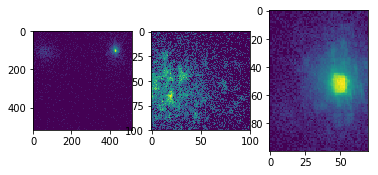

In [12]:
scan33 = load_edf([33],specdir,edfdir,specfile)[33]

# Select an ROI and visualise it
i1, i2 = 50, 150
j1, j2 = 50, 150
# Do the same for the Bragg
h1, h2 = 50, 150
k1, k2 = 380, 450

roi1_33 = scan33[i1:i2,j1:j2,0]
roi2_33 = scan33[h1:h2,k1:k2,0]

pl.subplot(1,3,1)
pl.imshow(np.log(scan33[:,:,0]))
pl.subplot(1,3,2)
pl.imshow(np.log(roi1_33));
pl.subplot(1,3,3)
pl.imshow(np.log(roi2_33));

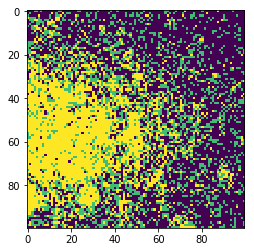

In [13]:
@interact(i=(0,120))
def plot(i):
    pl.imshow(np.log(scan33[i1:i2,j1:j2,i]),vmin=0,vmax=1)

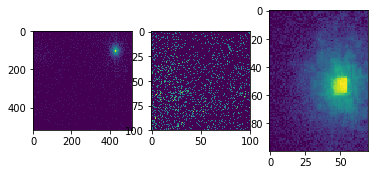

In [14]:
scan43 = load_edf([43],specdir,edfdir,specfile)[43]

# Select an ROI and visualise it
i1, i2 = 50, 150
j1, j2 = 50, 150
# Do the same for the Bragg
h1, h2 = 50, 150
k1, k2 = 380, 450

roi1_43 = scan43[i1:i2,j1:j2,0]
roi2_43 = scan43[h1:h2,k1:k2,0]

pl.subplot(1,3,1)
pl.imshow(np.log(scan43[:,:,0]))
pl.subplot(1,3,2)
pl.imshow(np.log(roi1_43));
pl.subplot(1,3,3)
pl.imshow(np.log(roi2_43));

## Try with `fftconvolve` 
I know most of this can go in a loop, but was still testing...

Compute the ACFs, reshape them to the correct 3D volume, see what it looks like:

In [15]:
acf_18 = np.array([])
acf_33 = np.array([])
acf_43 = np.array([])

for row in range(i1,i2):
    for pixel in range(j1,j2):
        
        acf_18 = np.append(acf_18, fftconvolve(scan18[row,pixel], np.flipud(scan18[row,pixel]), mode='same'))
        acf_33 = np.append(acf_33, fftconvolve(scan33[row,pixel], np.flipud(scan33[row,pixel]), mode='same'))
        acf_43 = np.append(acf_43, fftconvolve(scan43[row,pixel], np.flipud(scan43[row,pixel]), mode='same'))

In [16]:
acf_18=acf_18.reshape(100,100,121)
acf_33=acf_33.reshape(100,100,121)
acf_43=acf_43.reshape(100,100,121)

In [17]:
N = acf_18.shape[2] # same for 33 as well
lengths = range(N, N//2, -1)

half_acf_18 = acf_18[:,:,N//2:]
half_acf_33 = acf_33[:,:,N//2:]
half_acf_43 = acf_43[:,:,N//2:]

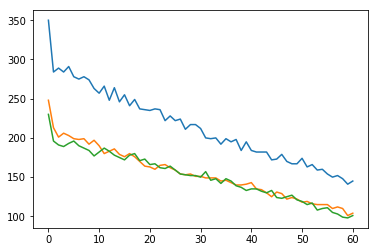

In [18]:
pl.plot(half_acf_18[0,0])
pl.plot(half_acf_33[0,0])
pl.plot(half_acf_43[0,0])

Divide by datapoints and normalise:

In [19]:
for row in range(half_acf_18.shape[0]):
    for pixel in range(half_acf_18.shape[1]):
        half_acf_18[row,pixel] /= lengths
for row in range(half_acf_18.shape[0]):
    for pixel in range(half_acf_18.shape[1]):
        half_acf_18[row,pixel] /= half_acf_18[row,pixel][0]

In [20]:
for row in range(half_acf_33.shape[0]):
    for pixel in range(half_acf_33.shape[1]):
        half_acf_33[row,pixel] /= lengths
for row in range(half_acf_33.shape[0]):
    for pixel in range(half_acf_33.shape[1]):
        half_acf_33[row,pixel] /= half_acf_33[row,pixel][0]

In [21]:
for row in range(half_acf_43.shape[0]):
    for pixel in range(half_acf_43.shape[1]):
        half_acf_43[row,pixel] /= lengths
for row in range(half_acf_43.shape[0]):
    for pixel in range(half_acf_43.shape[1]):
        half_acf_43[row,pixel] /= half_acf_43[row,pixel][0]

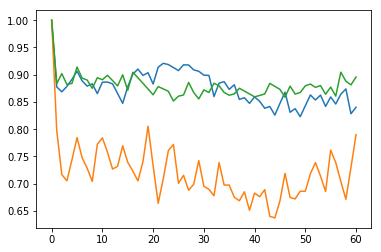

In [22]:
pl.plot(half_acf_18[30,30])
pl.plot(half_acf_33[30,30])
pl.plot(half_acf_43[30,30])

Plot the whole thing!

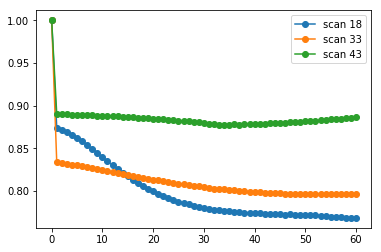

In [23]:
pl.plot(half_acf_18.sum(axis=0).sum(axis=0)/(half_acf_18.shape[0]*half_acf_18.shape[1]),'-o',label='scan 18')
pl.plot(half_acf_33.sum(axis=0).sum(axis=0)/(half_acf_33.shape[0]*half_acf_33.shape[1]),'-o', label='scan 33')
pl.plot(half_acf_43.sum(axis=0).sum(axis=0)/(half_acf_43.shape[0]*half_acf_43.shape[1]),'-o', label='scan 43')
pl.legend()
# pl.xscale('log')
pl.show()

Still don't understand very well the overall shift in correlation.

In [46]:
def nacf(x):
    acf = fftconvolve(x,np.flipud(x),mode='same')
    N = len(acf)
    half_acf = acf[N//2:]
    lengths = np.arange(N, N//2, -1)
    half_acf /= lengths
    half_acf /= half_acf[0]
    
    return half_acf

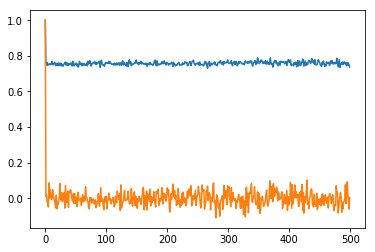

In [48]:
x = np.random.rand(1000)
y = np.random.randn(1000)
pl.plot(nacf(x))
pl.plot(nacf(y))


In [52]:
# pl.plot(x)
np.random.randn?